In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from _bootstrap import *
from polygon_processors import (
    PolygonSplitter,
    AttributeCalculator)
from paths import get_paths

input_dir, output_dir, plots_dir = get_paths()

polys = gpd.read_file(output_dir / "voronoi_data.shp")
points = gpd.read_parquet(input_dir / "synthetic_points.parquet")
points = points.to_crs(32719)

In [2]:
def filter_data(poly_id, polys, points):
  """Select one polygon and filter points within it."""
  poly = polys.loc[polys["block_id"]==poly_id]
  points_poly = points.sjoin(poly, how="inner", predicate="intersects").drop(columns=["index_left", "index_right"], errors="ignore")
  return poly, points_poly

# --- Step 1: Select target polygon and points ---
poly_id = "1311011100300300"

poly, points_in_poly = filter_data(poly_id, polys, points)

def recalculate_population(gdf, points):
  """Remove old population columns and recalculate."""
  gdf = gdf.drop(columns=["pop", "pop_low", "pop_middle", "pop_high"], errors="ignore")
  return AttributeCalculator(input_data=gdf, tolerance=0.3, pop_max=400)._calculate_population(points[["id", "geometry"]])

# Recalculate population based on the synthetic points
poly = recalculate_population(poly, points)

poly.head()

,commune_id,commune,block_id,zone_type,sregion_id,geometry,pop
0,13110,LA FLORIDA,1311011100300300,Urban,1311004,"POLYGON ((354751.625 6285832.278, 354786.62 62...",60


In [3]:
def update_block_ids(gdf):
  """Append cluster ID to block_id."""
  gdf["cluster"] = gdf["cluster"].astype(str).str.zfill(2)
  gdf["block_id"] = gdf["block_id"].str[:-2] + gdf["cluster"]
  return gdf

# --- Step 2: Cluster points ---
# pop_max is set to 20 to illustrate the division of the data into 3 distinct clusters
splitter = PolygonSplitter(input_data=poly, pop_max=20, tolerance=0.3, resolution=12)
n_clusters, pop_min, pop_max = splitter._calculate_pop_thresholds(poly)
print(f"Population: {poly['pop'].iloc[0]}, Clusters: {n_clusters}, Range: {pop_min}-{pop_max}")

points_clustered = splitter._cluster_points(points_in_poly, n_clusters, pop_min, pop_max)
centroids = splitter._generate_cluster_centroids(points_clustered)

# --- Step 3: Generate hex grid and dissolve ---
h3_grids, counts = splitter._generate_h3_grid_and_counts(points_clustered, poly)
dissolved = splitter._assign_clusters_to_hexes(h3_grids, counts, cluster_centroids_gdf=points_clustered)
dissolved = update_block_ids(dissolved)
dissolved = recalculate_population(dissolved, points)

# --- Step 4: Handle disconnected geometries ---
_, disconnected = splitter.identify_multipart_polygons(dissolved, "cluster", keep_largest=False)
if not disconnected.empty:
  print(f"Disconnected clusters: {len(disconnected)}")

dissolved_fixed = splitter.reassign_disconnected_parts(dissolved)
dissolved_fixed = update_block_ids(dissolved_fixed)
dissolved_fixed = recalculate_population(dissolved_fixed, points)

Population: 60, Clusters: 3, Range: 14-26
Disconnected clusters: 2


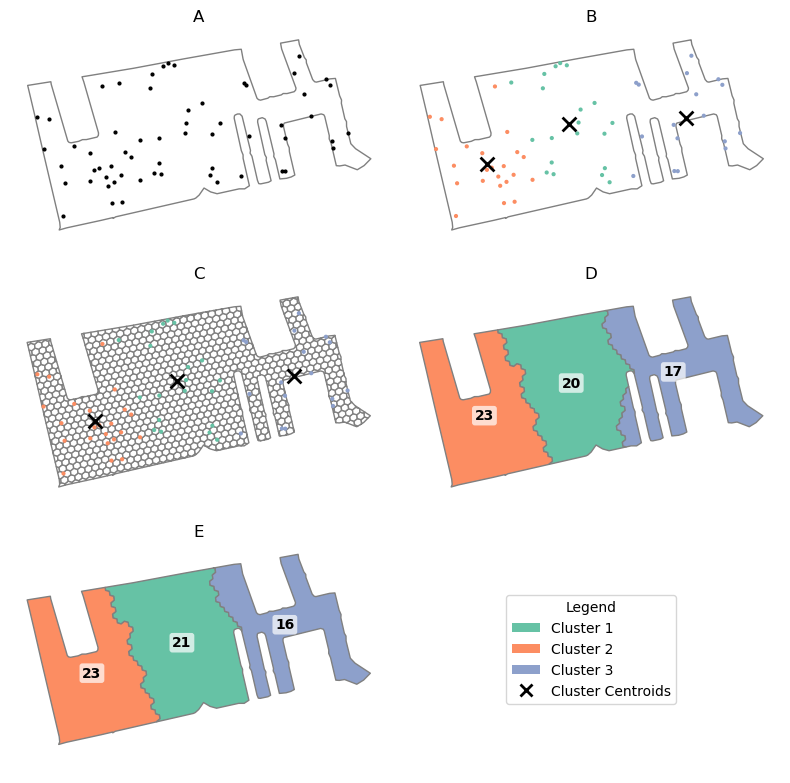

In [4]:
def get_color_dict(clusters, cmap_name='Set2'):
    cmap = plt.get_cmap(cmap_name)
    return {cluster: cmap(i % cmap.N) for i, cluster in enumerate(clusters)}

def plot_cluster_map(ax, base, points=None, centroids=None, title='', color_dict=None):
    base.plot(ax=ax, color='white', edgecolor='gray')
    
    if points is not None:
        if color_dict and 'cluster' in points.columns:
            color = points['cluster'].map(color_dict)
        else:
            color = 'black'
        points.plot(ax=ax, color=color, markersize=4)

    if centroids is not None:
        if color_dict and 'cluster' in centroids.columns:
            color = centroids['cluster'].map(color_dict)
        else:
            color = 'black'
        centroids.plot(ax=ax, color=color, marker='x', markersize=100, linewidth=2)
    
    ax.set_title(title, loc='center', fontsize=12)
    ax.set_axis_off()

def plot_pop_labels(ax, gdf, label_col='pop'):
    centroids = gdf.copy()
    centroids['centroid'] = centroids.geometry.centroid
    for _, row in centroids.iterrows():
        x, y = row['centroid'].x, row['centroid'].y
        ax.text(
            x, y, str(row[label_col]), ha='center', va='center', fontsize=10, fontweight='bold',
            color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
        )

def plot_dissolved(ax, gdf, title):
    clusters = sorted(gdf["cluster"].unique())
    color_dict = get_color_dict(clusters)
    gdf.plot(ax=ax, color=gdf["cluster"].map(color_dict), edgecolor='gray')
    plot_pop_labels(ax, gdf)
    ax.set_title(title, loc='center', fontsize=12)
    ax.set_axis_off()
    return color_dict

def create_shared_legend(ax, clusters, color_dict):
    handles = [Patch(facecolor=color_dict[c], label=f'Cluster {c}') for c in clusters]
    handles.append(Line2D([0], [0], marker='x', color='black', label='Cluster Centroids',
                          linestyle='None', markersize=8, markeredgewidth=2))
    ax.legend(handles=handles, title='Legend', loc='center', fontsize=10, title_fontsize=10)
    ax.axis('off')


# --- Plot Setup ---
fig, axs = plt.subplots(3, 2, figsize=(8, 8))
axs = axs.flatten()

# Plot A – Raw points
plot_cluster_map(axs[0], poly, points_in_poly, title='A')

# Plot B – Clustered points + centroids
clusters_b = sorted(points_clustered["cluster"].unique())
color_dict_b = get_color_dict(clusters_b)
plot_cluster_map(axs[1], poly, points_clustered, centroids, title='B', color_dict=color_dict_b)

# Plot C – H3 Grid
plot_cluster_map(axs[2], h3_grids, points_clustered, centroids, title='C', color_dict=color_dict_b)

# Plot D – Dissolved polygons + pop labels
color_dict_d = plot_dissolved(axs[3], dissolved, 'D')

# Plot E – Fixed dissolved polygons + pop labels
color_dict_e = plot_dissolved(axs[4], dissolved_fixed, 'E')

# Plot F – Shared legend (bottom right)
create_shared_legend(axs[5], clusters_b, color_dict_b)

plt.tight_layout()
plt.show()
